# Lab — Outliers

![Outlier meme](https://raw.githubusercontent.com/dcai-course/assets/master/outlier-meme.jpg)

You are given a clean dataset consisting of many pictures of dogs (the data distribution), and an evaluation dataset that contains outliers (dogs mixed with non-dogs). Your task is to implement and compare various methods for detecting outliers (strictly speaking, this is an anomaly detection task, because you're given a clean training set). You may implement some of the ideas presented in today's lecture, or you can look up other outlier detection algorithms in the linked references or online.

## Install dependencies

If you don't have them installed already, run the following cell.

In [ ]:
!pip install Pillow matplotlib numpy scikit-learn tqdm

## Download and extract the dataset

We're working with a ~ 1.3 GB image dataset in this lab. Either download and extract it manually, or run the following cells.

In [ ]:
!wget -nc https://github.com/dcai-course/dcai-lab/releases/download/v0.0.0/outliers.tar.gz
!tar xzf outliers.tar.gz

## Visualize some of the data

In [1]:
import os
import numpy as np
from tqdm import tqdm

train_files = sorted([os.path.join('train', i) for i in os.listdir('train') if i.endswith('.JPEG')])
test_files = sorted([os.path.join('test', i) for i in os.listdir('test') if i.endswith('.JPEG')])
np.random.seed(1337) # for reproducibility
np.random.shuffle(train_files)
np.random.shuffle(test_files)
# ground truth, used for evaluation of your outlier detection implementation
with open('outliers_ground_truth.txt') as f:
    test_outliers = [os.path.join('test', i) for i in f.read().strip().split('\n')]
    test_outliers_mask = np.array([i in test_outliers for i in test_files])

In [5]:
len(test_outliers)

2646

In [6]:
import matplotlib.pyplot as plt
import PIL

def plot_images(paths, per_row=5):
    '''
    Visualize images by their paths.
    
    Shows whether an image is an outlier or not, using the ground-truth information.
    '''
    n = len(paths)
    cols = per_row
    rows = n // per_row
    plt.rcParams["figure.figsize"] = (15,4*rows)
    for i, path in enumerate(paths):
        ax = plt.subplot(rows, cols, i+1)
        img = PIL.Image.open(path)
        img = np.asarray(img)
        ax.imshow(img)
        if path in test_outliers:
            ax.set_title('outlier')
        ax.axis('off')
    plt.show()

First, let's visualize the training distribution:

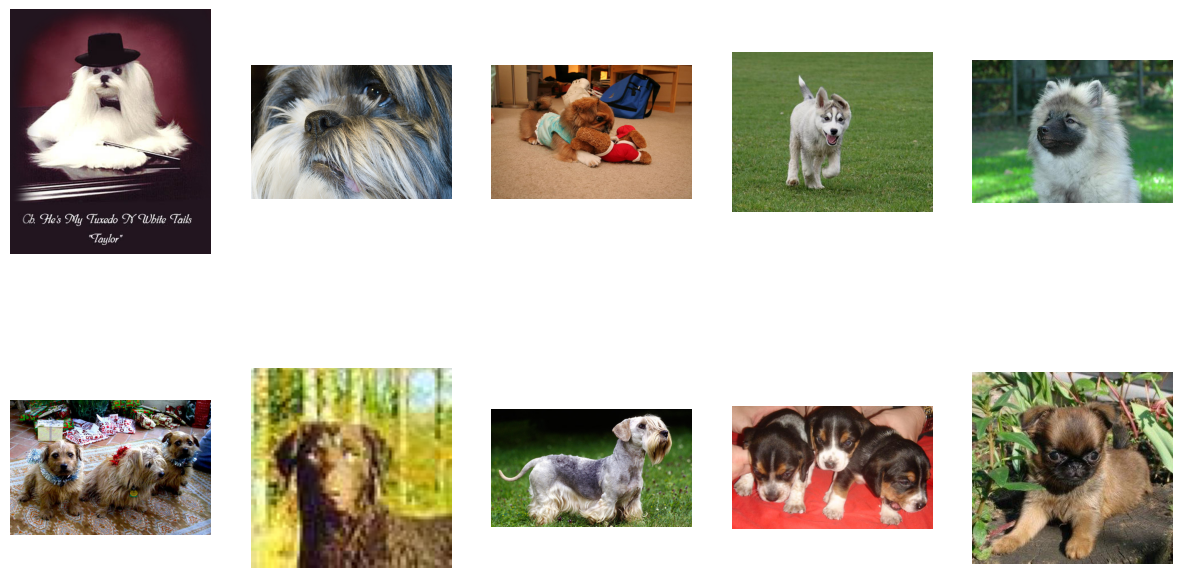

In [7]:
plot_images(train_files[:10])

Now, let's visualize the test distribution (which contains some outliers). The visualization code uses the ground-truth information to label outliers. Our goal in this lab is to find these outliers automatically.

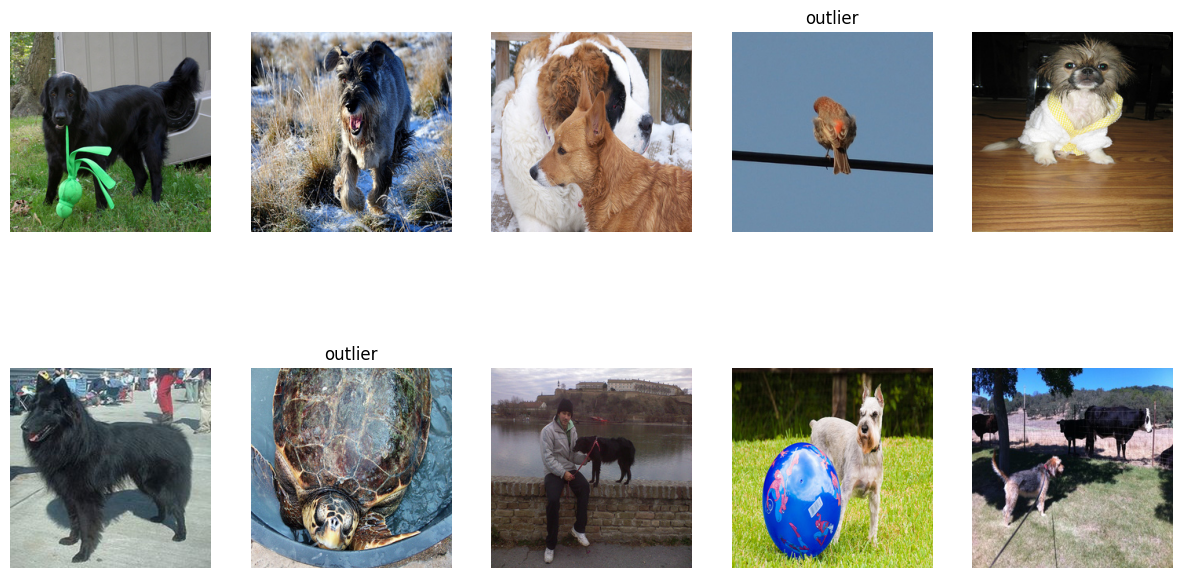

In [8]:
plot_images(test_files[:10])

## Evaluation metrics

Most methods we implement will assign as score to every datapoint, and we'll have to choose a threshold to decide which data points we consider outliers. To evaluate such methods, we can look at an ROC curve (true positive rate vs false positive rate), and if we want a single summary number, look at the AUROC (area under the ROC curve).

Here, we define some utilities to plot ROC curves for you.

In [9]:
from sklearn import metrics

def plot_roc(*scores_and_names):
    '''
    Plots an ROC curve and computes AUC, given a list of scores and method names.
    
    Call this function like plot_roc(scores1, 'name of method 1', scores2, 'name of method 2', ...)
    to compare different outlier detection methods.
    '''
    fpr = []
    tpr = []
    for score, name in zip(scores_and_names[::2], scores_and_names[1::2]):
        fpr, tpr, thresholds = metrics.roc_curve(test_outliers_mask, score)
        auc = metrics.roc_auc_score(test_outliers_mask, score)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
    plt.legend(loc=0)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

## Baseline methods

Here, we implement a couple really simple methods, just to show you how the pieces fit together. You can do a _lot_ better than these.

We want to compute a score for each datapoint that indicates how likely it is (compared to the others) to be an outlier (in this lab, these scores do not need to be calibrated as anything like probabilities, they just need to be meaningful relative to each other). The score for a datapoint is calculated based on the test image and features of the train distribution, but _not_ taking into account other datapoints in the test set or information on which other images in the test set are outliers or not.

### Random scores

The most basic baseline: assign each datapoint a random score.

Check yourself: what do you expect the ROC curve to look like, and what will be the AUC? Does this depend on what fraction of the dataset are outliers?

In [10]:
np.random.seed(1234)
random_ood_scores = np.random.uniform(size=len(test_files))

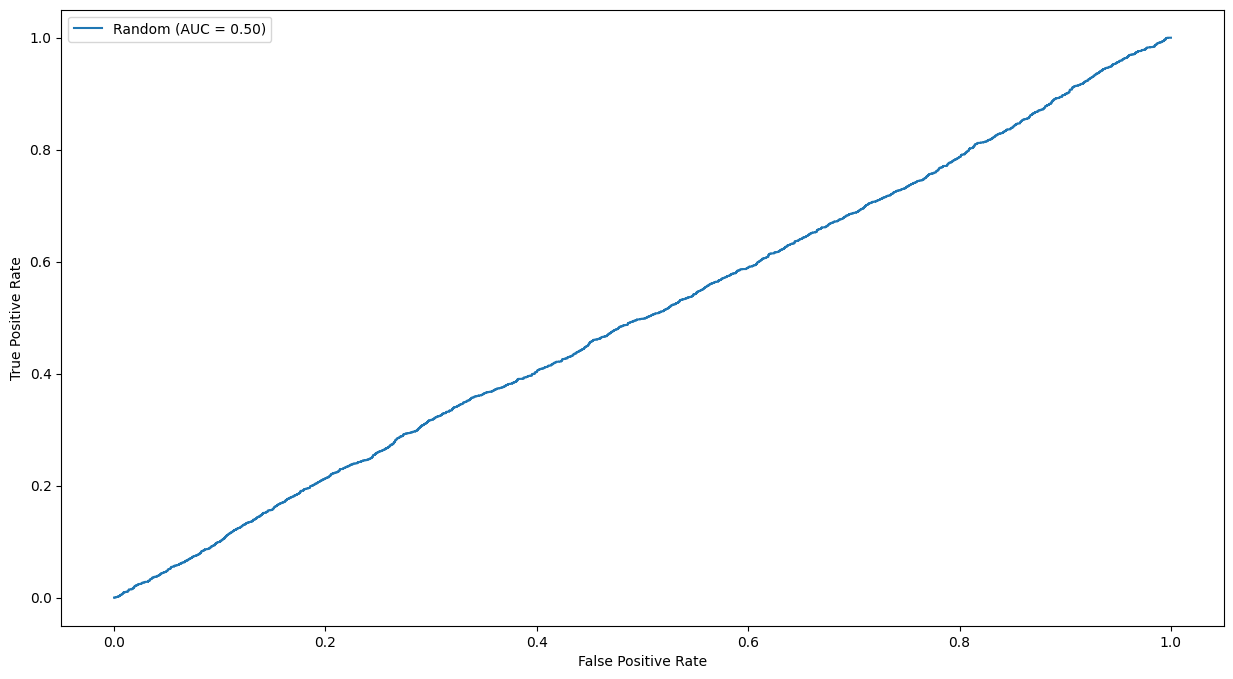

In [11]:
plot_roc(random_ood_scores, 'Random')

### Average color

As a really simple score, we can compute the average color of in-distribution images, and for a new image, compute its score as the difference between its average color and the average color of training images.

In [12]:
train_mean_pixel = np.zeros(3)
for path in tqdm(train_files):
    train_mean_pixel += np.asarray(PIL.Image.open(path).convert('RGB')).mean(axis=(0, 1))
train_mean_pixel /= len(train_files)

  0%|          | 0/10030 [00:00<?, ?it/s]

100%|██████████| 10030/10030 [00:48<00:00, 208.48it/s]


In [13]:
train_mean_pixel

array([122.31531366, 116.26996395, 101.4417825 ])

In [14]:
mean_pixel_ood_scores = []
for path in tqdm(test_files):
    img_mean_pixel = np.asarray(PIL.Image.open(path).convert('RGB')).mean(axis=(0, 1))
    diff = np.sum(np.abs(img_mean_pixel - train_mean_pixel))
    mean_pixel_ood_scores.append(diff)
mean_pixel_ood_scores = np.array(mean_pixel_ood_scores)

100%|██████████| 8546/8546 [00:17<00:00, 501.53it/s]


In [15]:
mean_pixel_ood_scores

array([ 84.50339373,  27.91386994, 104.26198713, ..., 180.0483156 ,
        74.05031403,  70.23223249])

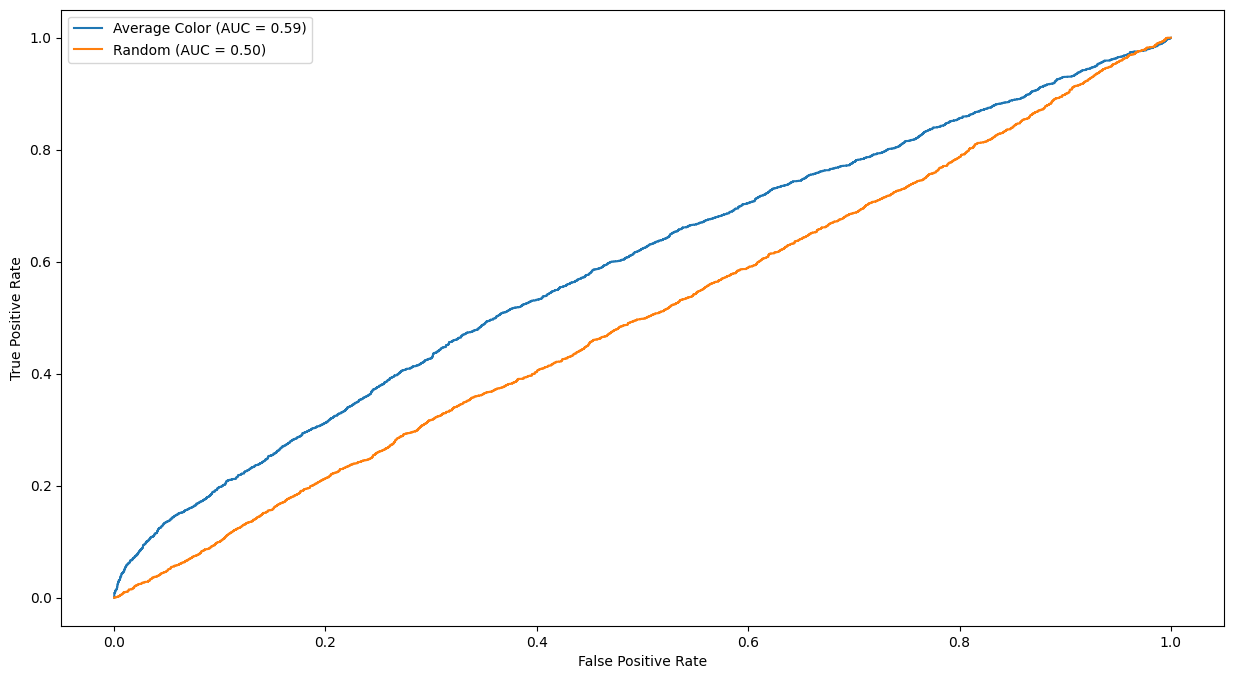

In [16]:
plot_roc(mean_pixel_ood_scores, 'Average Color', random_ood_scores, 'Random')

### KNN in image space, on resized images

It's not sensible to do KNN in image space, because the images are really large. But we can try resizing them to some fixed size, like 32x32, and doing KNN with L2 distance in that space.

In [ ]:
#!pip install cleanlab

In [17]:
train_tiny_image_reps = []
for path in tqdm(train_files):
    train_tiny_image_reps.append(np.asarray(PIL.Image.open(path).convert('RGB').resize((32, 32))).flatten())
train_tiny_image_reps = np.stack(train_tiny_image_reps)

100%|██████████| 10030/10030 [00:35<00:00, 283.07it/s]


In [18]:
train_tiny_image_reps.shape

(10030, 3072)

In [20]:
test_tiny_image_reps = []
for path in tqdm(test_files):
    test_tiny_image_reps.append(np.asarray(PIL.Image.open(path).convert('RGB').resize((32, 32))).flatten())
test_tiny_image_reps = np.stack(test_tiny_image_reps)

100%|██████████| 8546/8546 [00:13<00:00, 616.16it/s]


In [21]:
test_tiny_image_reps.shape 

(8546, 3072)

In [22]:
from cleanlab.outlier import OutOfDistribution

tiny_ood = OutOfDistribution()
tiny_ood.fit(features=train_tiny_image_reps)
tiny_ood_scores = -tiny_ood.score(features=test_tiny_image_reps)

Fitting OOD estimator based on provided features ...


In [24]:
len(tiny_ood_scores)

8546

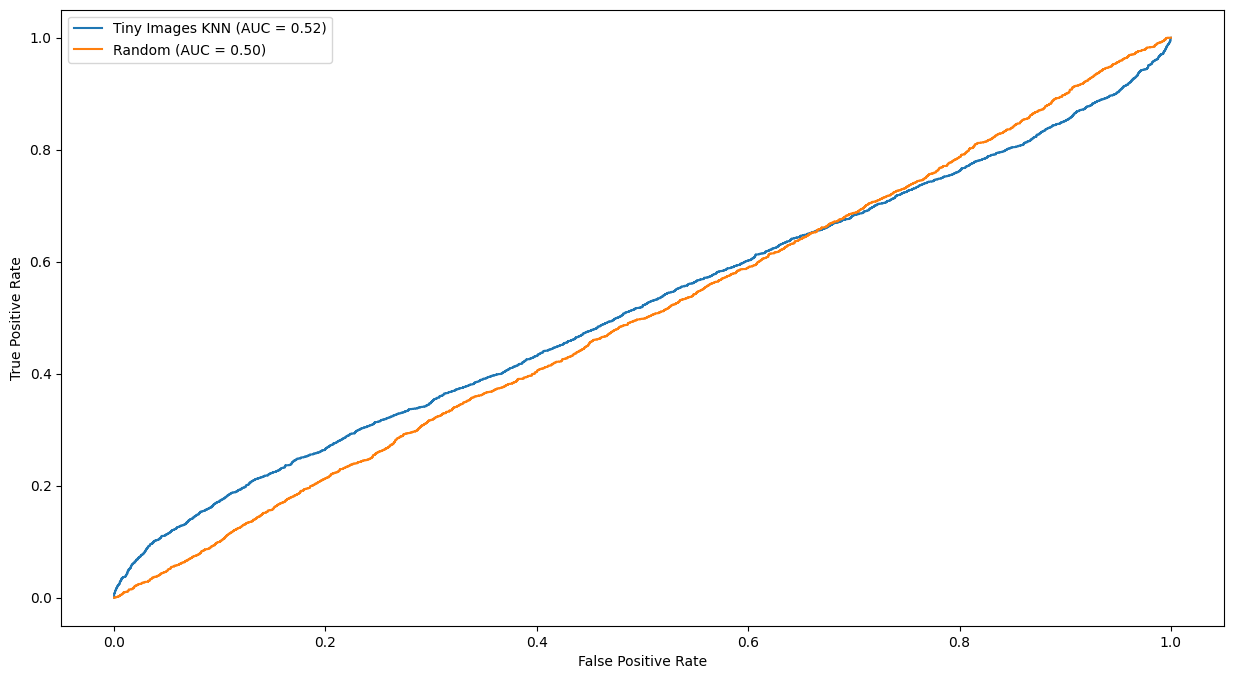

In [25]:
plot_roc(tiny_ood_scores, 'Tiny Images KNN', random_ood_scores, 'Random')

### Isolation forest on image histograms

It's not sensible to use the isolation forest algorithm directly on the high-dimensional image data, but we can try it on features computed from the image. Here, we compute image histograms as features.

In [26]:
def compute_histograms(paths):
    all_hists = []
    for path in tqdm(paths):
        x = np.asarray(PIL.Image.open(path).convert('RGB').resize((256, 256)))
        hists = []
        for c in range(3):
            hist, _ = np.histogram(x[:,:,c], bins=32, range=(0, 256))
            hists.append(hist)
        hist = np.concatenate(hists)
        all_hists.append(hist)
    return np.stack(all_hists)

In [27]:
train_histograms = compute_histograms(train_files)

100%|██████████| 10030/10030 [01:03<00:00, 156.72it/s]


In [29]:
train_histograms.shape

(10030, 96)

In [30]:
test_histograms = compute_histograms(test_files)

100%|██████████| 8546/8546 [00:31<00:00, 273.25it/s]


In [31]:
test_histograms.shape

(8546, 96)

In [32]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
isolation_forest.fit(train_histograms)

isolation_scores = -isolation_forest.score_samples(test_histograms) # negate, so higher score = more abnormal

In [33]:
len(isolation_scores)

8546

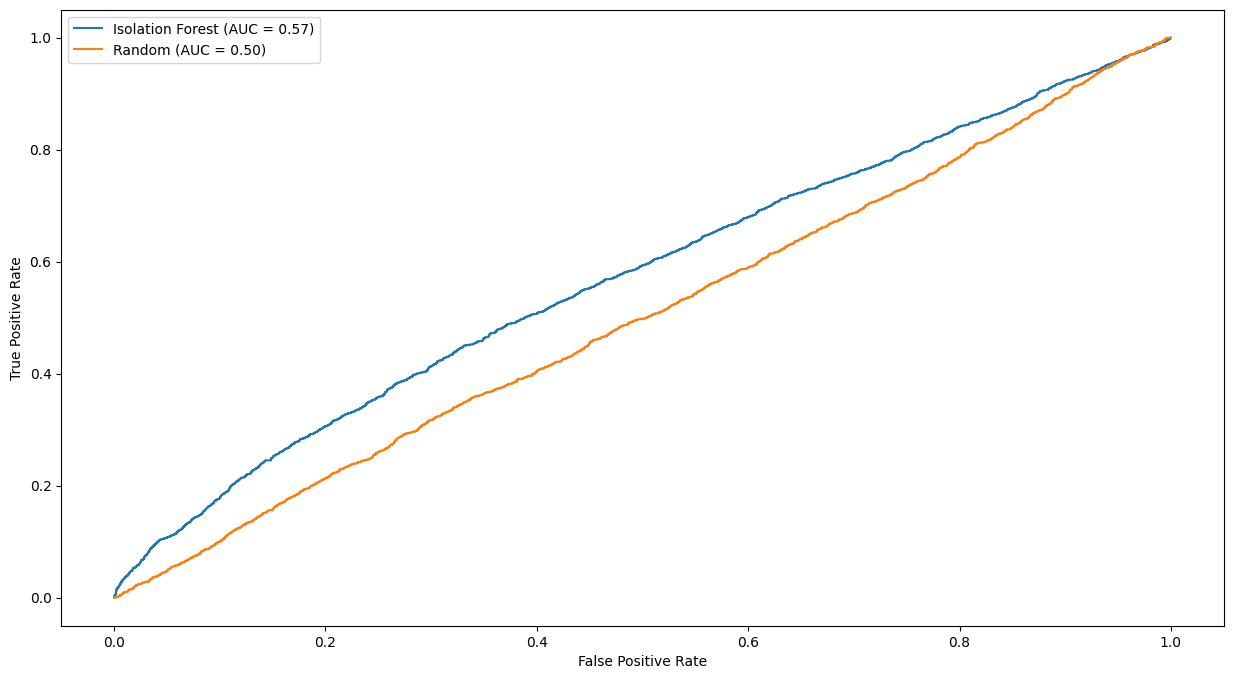

In [34]:
plot_roc(isolation_scores, 'Isolation Forest', random_ood_scores, 'Random')

### Comparing the (very simple) methods we implemented

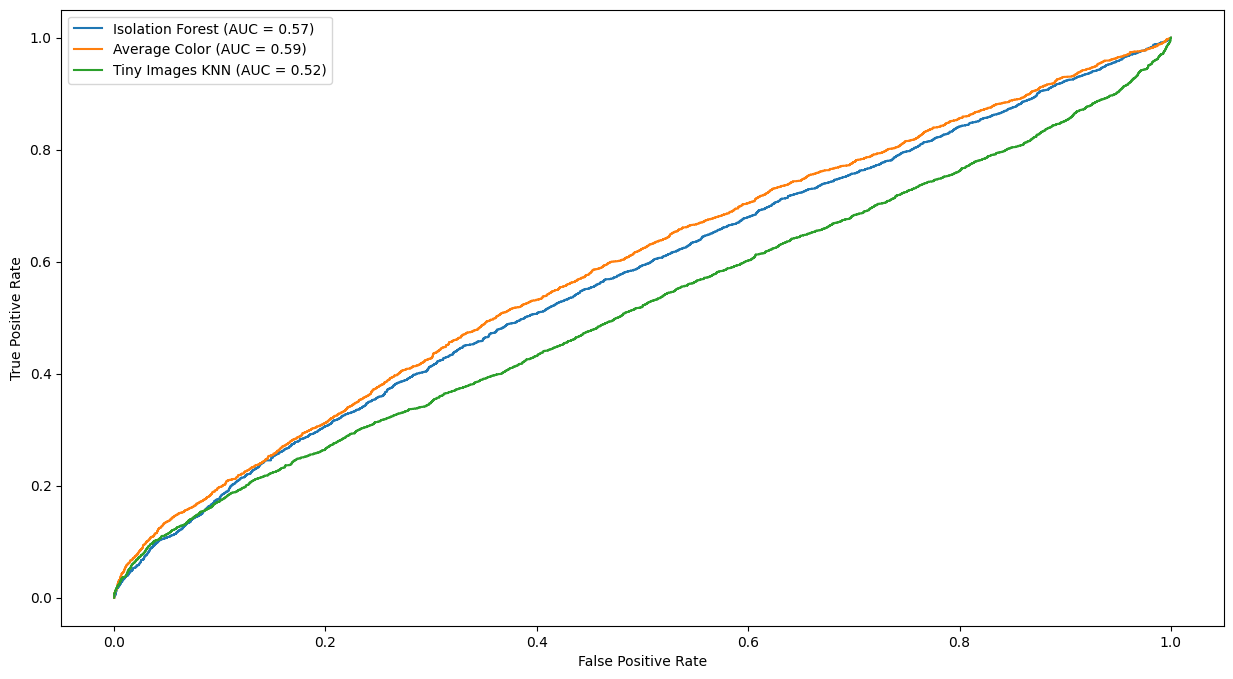

In [35]:
plot_roc(isolation_scores, 'Isolation Forest', mean_pixel_ood_scores, 'Average Color', tiny_ood_scores, 'Tiny Images KNN')

## Exercise: implement and compare outlier detection methods

Implement and compare various methods for outlier detection to find outliers in the test set (`test_files`). Ground-truth information, used for evaluating your outlier detection algorithm, is in `test_outliers` / `test_outliers_mask`.

You should compute a score for each datapoint.  The scores should be computed based as a function of each test image (that may depend on statistics of the training data), but not any information about the other test images or which test examples are outliers or not. That means, for example, that you can't train a binary classifier on whether an image is in-distribution or out-of-distribution by using the outlier images and "labels" in `test_outliers` (that is only for evaluation). The scenario is that you've been able to train on the train distribution, and then an anomaly detection system is deployed "live", where it handles one datapoint that it sees at a time (and never gets ground-truth information on whether that datapoint was an outlier).

We want scores to take higher values for test images which are actually outliers vs those which are not.

As one of the methods you implement, we suggest using embeddings from a pre-trained model and using KNN distance as a score. A good place to find pre-trained models is [HuggingFace](https://huggingface.co/models). Another good place to look is the timm library; here is a [tutorial on feature extraction](https://huggingface.co/docs/timm/feature_extraction). You can find a list of timm models [here](https://huggingface.co/docs/timm/models).

Another idea is to train an autoencoder and use reconstruction loss as a score. You might find [this tutorial](https://towardsdatascience.com/simplifing-image-outlier-detection-with-alibi-detect-6aea686bf7ba) helpful.

You should be able to get to AUROC > 0.95.

The dataset used in this lab is taken from ImageNet (train data comes from the ImageNet train set, and test data comes from the ImageNet validation set). Many pre-trained models available online are trained on ImageNet. How does this help explain the great performance of the pre-trained model + KNN distance method?

After implementing a couple different methods, compare them using `plot_roc`.

Also, you might find it interesting to qualitiatively evaluate your outlier detection implementations. Plot the highest-scoring images and the lowest-scoring images using `plot_images`.

In this solution, we implement the method using KNN distance on embeddings from a pre-trained model. We choose a pre-trained ResNet-50 model from HuggingFace.

In [ ]:
!pip install transformers torch cleanlab

### Compute embeddings

In [36]:
from transformers import AutoFeatureExtractor, ResNetForImageClassification
import torch

In [37]:
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
# use GPU if available
if torch.cuda.is_available():
    model = model.to('cuda:0')

/Users/diwu/opt/miniconda3/envs/torch/lib/python3.9/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [46]:
def chunks(l, n):
    return [l[i:i+n] for i in range(0, len(l), n)]

In [47]:
def compute_embeddings(paths, batch_size=50):
    embeddings = None
    for chunk in tqdm(chunks(paths, batch_size)):
        images = [PIL.Image.open(i).convert('RGB') for i in chunk]
        inputs = feature_extractor(images, return_tensors="pt")
        if torch.cuda.is_available():
            inputs = inputs.to('cuda:0')
        with torch.no_grad():
            outputs = model(**inputs)
        embedding = outputs.logits.cpu().numpy()
        if embeddings is None:
            embeddings = embedding
        else:
            embeddings = np.vstack([embeddings, embedding])
    return embeddings

In [48]:
train_embeddings = compute_embeddings(train_files)

  6%|▋         | 13/201 [01:19<19:14,  6.14s/it]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 train_embeddings = compute_embeddings(train_files)                                           │
│   2                                                                                              │
│                                                                                                  │
│ in compute_embeddings:9                                                                          │
│                                                                                                  │
│    6 │   │   if torch.cuda.is_available():                                                       │
│    7 │   │   │   inputs = inputs.to('cuda:0')                                                    │
│    8 │   │   with torch.no_grad():                                                               │
│ ❱  9 │   │   │   outputs = model(**inputs)                                                       │
│   10 │   │   embedding = outputs.logits.cpu().numpy()                                            │
│   11 │   │   if embeddings is None:                                                              │
│   12 │   │   │   embeddings = embedding                                                          │
│                                                                                                  │
│ /Users/diwu/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torch/nn/modules/module.py:150 │
│ 1 in _call_impl                                                                                  │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /Users/diwu/opt/miniconda3/envs/torch/lib/python3.9/site-packages/transformers/models/resnet/mod │
│ eling_resnet.py:390 in forward                                                                   │
│                                                                                                  │
│   387 │   │   """                                                                                │
│   388 │   │   return_dict = return_dict if return_dict is not None else self.config.use_return   │
│   389 │   │                                                                                      │
│ ❱ 390 │   │   outputs = self.resnet(pixel_values, output_hidden_states=output_hidden_states, r   │
│   391 │   │                                                                                      │
│   392 │   │   pooled_output = outputs.pooler_output if return_dict else outputs[1]               │
│   393                                                                                            │
│                                                                                                  │
│ /Users/diwu/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torch/nn/modules/module.py:150 │
│ 1 in _call_impl                                            

In [30]:
test_embeddings = compute_embeddings(test_files)

100%|███████████████████████████████████████████████████████████████████████████████████████| 171/171 [00:21<00:00,  7.86it/s]


### Find OOD data

In [31]:
from cleanlab.outlier import OutOfDistribution

ood = OutOfDistribution()

ood.fit(features=train_embeddings)

ood_test_scores = -ood.score(features=test_embeddings)

Fitting OOD estimator based on provided features ...


For fun, let's visualize some of the results. Here are some of the highest-scoring images (most likely to be outliers):

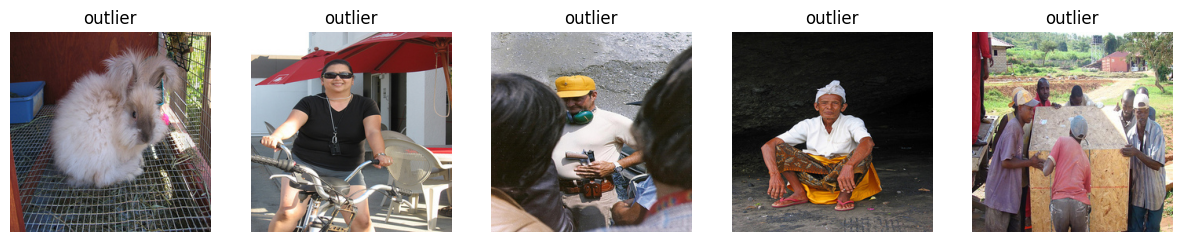

In [32]:
idx_by_score = np.argsort(ood_test_scores)
plot_images(np.array(test_files)[idx_by_score[-5:]])

And here are some of the lowest-scoring images (least likely to be outliers):

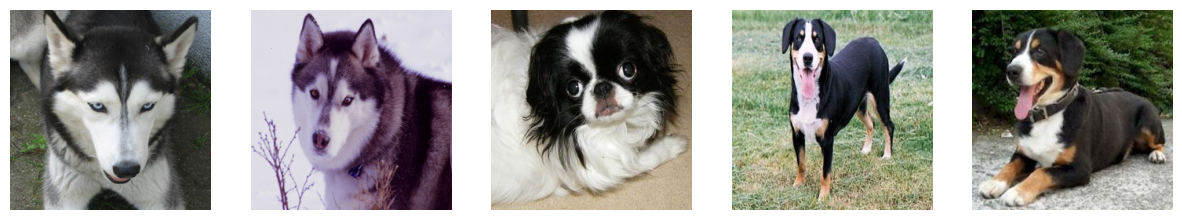

In [33]:
plot_images(np.array(test_files)[idx_by_score[:5]])

Finally, let's look at the ROC curve and the AUC:

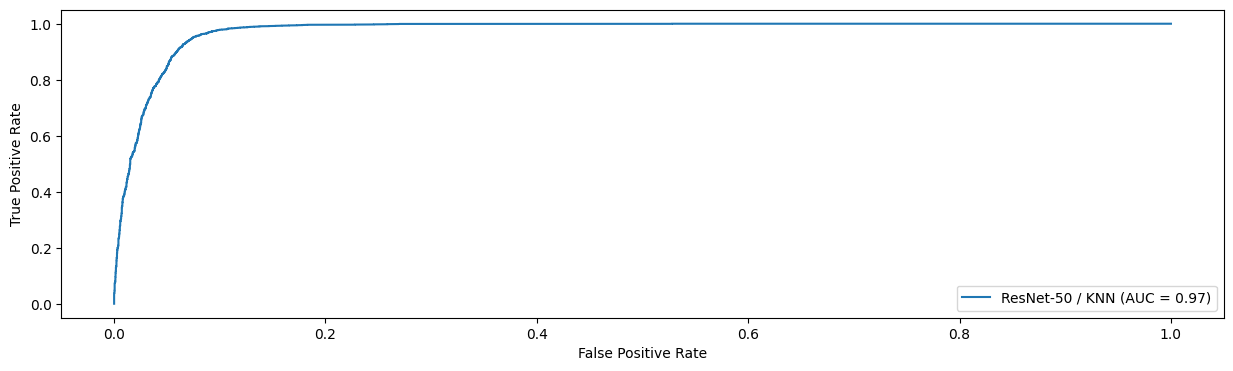

In [34]:
plot_roc(ood_test_scores, 'ResNet-50 / KNN')